# Create data matrix

In [1]:
#import csv
#from datetime import datetime
import matplotlib.pyplot as plt
#import matplotlib
import numpy as np
import sklearn
#import scipy
#import random
from sklearn.cluster import DBSCAN
#import math
from scipy.spatial import distance

In [2]:
### Function to save results as .txt files
import pickle
def pick(file, name):
    with open('./ira_txt_1/' + name + '.txt', "wb") as fp:   #Pickling
        pickle.dump(file, fp)
def unpick(name):
    with open('./ira_txt_1/' + name + '.txt', "rb") as fp:   # Unpickling
        file = pickle.load(fp)
    return file

In [3]:
total_users = 3667
total_tweets = 9041308
total_days = 3331

In [4]:
tweet_days = unpick('date_vectors')
bin_data_m = unpick('bin_data_matrix')
data_m = unpick('data_matrix')

In [5]:
def make_binary(vect):
    a = np.copy(vect)
    a[a > 0] = 1
    return a
binary_date_vectors = {}
for user in tweet_days:
    binary_date_vectors[user] = make_binary(tweet_days[user])
pick(binary_date_vectors,'bin_date_vectors')

In [6]:
binary_date_vectors = unpick('bin_date_vectors')

In [7]:
def test_dict(D):
    T = 0
    for user in D:
        v = D[user]
        T += np.sum(v)
    return T

In [8]:
print(np.sum(data_m),data_m.shape)
print(np.sum(bin_data_m),bin_data_m.shape)
print(test_dict(tweet_days),test_dict(binary_date_vectors))

9041308 (3667, 3331)
563006 (3667, 3331)
9041308 563006


# Distances

In [9]:
### Calculate similarity matrices

import time

t0 = time.time()
dist_j = sklearn.metrics.pairwise_distances(bin_data_m, metric='jaccard')
t1 = time.time()
total = t1-t0

dist_h = sklearn.metrics.pairwise_distances(bin_data_m, metric='hamming')
binary_cor = np.corrcoef(bin_data_m)
pick(binary_cor,'binary_cor')
pick(dist_j,'dist_j')
pick(dist_h,'dist_h')

C:\Users\macki\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [10]:
print(total)

55.17450666427612


In [11]:
dist_j = unpick('dist_j')
dist_h = unpick('dist_h')
binary_cor = unpick('binary_cor')

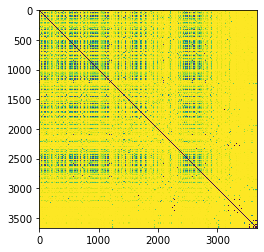

In [12]:
plt.imshow(dist_j)

In [13]:
lines = []

j0 = 1 - dist_j[np.triu_indices(3667,1)]
h0 = 1 - dist_h[np.triu_indices(3667,1)]
c0 = binary_cor[np.triu_indices(3667,1)]

for i in range(len(j0)):
    lines.append((j0[i],h0[i],c0[i]))

In [14]:
lines.sort(key=lambda tup: tup[2]) 

KeyboardInterrupt: 

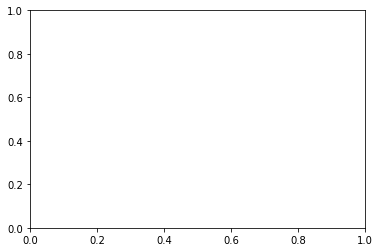

In [15]:
f, ax = plt.subplots(1)
for i in range(3):
    y = []
    for j in range(len(lines)):
        y.append(lines[j][i])
    if i == 2:ax.plot(y, c = 'r')
    else:ax.scatter(range(len(y)), y, s = 1, marker = '.')

ax.set_ylim([-0.7, 1.05])
ax.axes.get_xaxis().set_visible(False)
plt.show()

In [ ]:
j = np.array(sorted(1 - dist_j[np.triu_indices(3667,1)]))
h = np.array(sorted(1 - dist_h[np.triu_indices(3667,1)]))
c = np.array(sorted(binary_cor[np.triu_indices(3667,1)]))

In [ ]:
f, ax = plt.subplots(1)
ax.plot(j)
ax.plot(h)
ax.plot(c)
ax.set_ylim([-0.3, 1.05])
ax.axes.get_xaxis().set_visible(False)
plt.show()

# Clustering

In [16]:
def duplicate(testList, n):
    for _ in range(n):
        testList.append([])
    return testList

def list_cls(labs):
    cl = duplicate([],max(labs) + 1)
    for i in range(len(labs)):
        cl[labs[i]].append(i)
    return cl

In [17]:
### Perfrom DBSCAN clustering
def cluster(dist, ep, ms):
    clustering = DBSCAN(eps=ep, min_samples=ms, metric='precomputed').fit(dist)
    L = clustering.labels_
    return L

def silhouette(L, dist):
    avg = sklearn.metrics.silhouette_score(dist, L, metric='precomputed')
    ary = sklearn.metrics.silhouette_samples(dist, L, metric='precomputed')
    for i in range(len(L)):
        if L[i] == -1: ary[i] = 0
    adjusted = np.mean(ary)
    raw = avg
    return raw, adjusted

def process_labels(ls):
    labs = np.array(ls) + 1
    clusters = np.max(labs)
    clusterNo, clusterS = np.unique(labs, return_counts=True)
    return clusters, clusterNo, clusterS

def score_clustering(ls, dist):
    raw, adjusted = silhouette(ls, dist)
    number, array, sizes = process_labels(ls)
    clustered = np.sum(sizes[1:number+1])
    unclustered = sizes[0]
    percent = clustered / ( clustered + unclustered )
    loc = list_cls(np.array(ls)+1)
    sizes = list(map(len, loc))
    sizes = np.array(sizes)
    avg_size = np.mean(sizes[1:])
    return adjusted, percent * 100, avg_size

In [18]:
ls = cluster(dist_j, 0.29, 5)
print(score_clustering(ls, dist_j))

(0.28427749270987024, 50.61358058358331, 24.103896103896105)


In [19]:
eps = np.arange(0.01,1,0.01)
mss = range(1,10)

In [ ]:
results = []
t = 0
for i in eps:
    for j in mss:
        ls = cluster(dist_j, i, j)
        adj, pct, avg = score_clustering(ls, dist_j)
        res = (i, j, adj, pct, avg)
        results.append(res)
    t += 1
    if t == 25: print('25pct')
    if t == 50: print('50pct')
    if t == 75: print('75pct')

In [20]:
z = []
x = []
y = []
cs = []
ss = []

w = 0.4

for result in results:
    (i, j, adj, pct, avg) = result
    z.append( (w) * adj - (1-w) * (avg ** -1) )
    x.append(i)
    y.append(j)
    cs.append('deepskyblue')
    ss.append(15)

NameError: name 'results' is not defined

In [21]:
m = z.index(max(z))
print(results[m])
cs[m] = 'r'
ss[m] = 40

ValueError: max() arg is an empty sequence

In [22]:
#id5 = np.copy((np.array(y) == 5).nonzero()[0])
#m5 = z.index(max(np.take(z,id5)))
#print(results[m5])
#cs[m5] = 'g'
#ss[m5] = 40

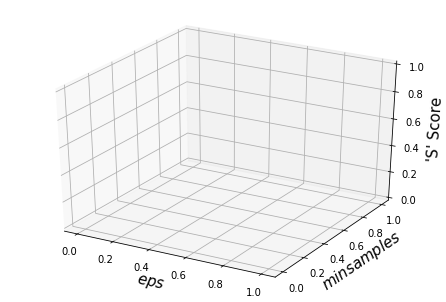

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, s=ss, c=cs, depthshade=True)

ax.set_xlabel('$eps$', fontsize=15, rotation=150)
ax.set_ylabel('$min samples$', fontsize=15)
ax.set_zlabel('\'S\' Score', fontsize=15, rotation=60)

plt.show()

In [24]:
#best_eps = 0.28
#best_min = 2
best_eps = 0.29
best_min = 5

In [ ]:
t0 = time.time()

ls = cluster(dist_j, best_eps, best_min)
#ls = cluster(dist_j, 0.28, 10)
print(score_clustering(ls, dist_j))
labels = np.array(ls) + 1
index, size = np.unique(labels, return_counts=True)
print(size[1:].tolist())
print(np.sum(size[1:]))
print(size[0])
loc = list_cls(labels)
sizes = list(map(len, loc))
sizes = np.array(sizes)
print(np.mean(sizes[1:]))

t1 = time.time()
total = t1-t0

In [ ]:
print(total)

In [ ]:
plt.scatter(labels, range(len(labels)))
plt.show()

In [25]:
def get_data(cluster):
    D = []
    A = []
    for i in cluster:
        v = bin_data_m[i]
        a = np.zeros(3331)
        dates = np.nonzero(v)
        first = dates[0][0]
        last = dates[0][-1]
        a[first:last+1] = 1
        A.append(a)
        D.append(v)
    return np.array(D), np.array(A)

def plot_data(D, A):
    users, days = D.shape
    print('Users: ', users)
    dates = np.nonzero(np.sum(D,0))
    first = dates[0][0]
    last = dates[0][-1] + 1
    
    active_users = np.sum(A,0)[first:last]
    activity = np.sum(D,0)[first:last] / active_users
        
    f, (a1, a2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
    f.set_figwidth(14)
    a1.scatter(range(len(activity)), activity)
    a1.set_ylim([-0.05, 1.05])
    
    X = np.zeros((users, last-first),int)
    X[:] = range(last-first)
    c = np.array(range(users)) + 1
    Y = np.multiply(D[:,first:last].transpose(), c).transpose()
    
    a2.scatter(X, Y, marker = '.', s = 1)
    plt.show()
    
def present_cluster(cluster):
    D, A = get_data(cluster)
    if np.sum(D) > 5: plot_data(D, A)

In [ ]:
loc = list_cls(labels)
pick(loc, 'loc')
print('clusters: ', len(loc))
for x in range(len(loc)):
    present_cluster(loc[x])
    if x == 1: break

In [26]:
import math
import pandas as pd
from datetime import datetime
from datetime import timedelta

### Turns date object to number and number to dateobject
def date_num(date):
    return (date - first_tweet).days
def num_date(num):
    return(first_tweet + timedelta(days = num))

def date_axis(start, xn, p):
    times = pd.date_range(start, periods=xn, freq=p)
    return times

first_tweet = datetime(2009,5,9).date()
last_tweet = datetime(2018,6,21).date()
days = 3331
weeks = int(math.ceil(days/7))
day_x = date_axis('2009-05-09', days, 'D')
week_x = date_axis('2009-05-09', weeks, 'W')
s_date = '2009-05-09'
e_date = '2018-06-21'

In [36]:
bdm = bin_data_m

In [ ]:
for i in range(1):
    cl = 3
    group = loc[cl].copy()
    bdm = bin_data_m

    k = 0
    f, ax = plt.subplots(1,1)
    #if h > 30: h = 10
    #f.set_figheight(h)
    f.set_figwidth(12)
    temp = np.zeros(3331,int)
    for i in group:
        k += 1
        x = bdm[i]
        temp += x
        ax.scatter(day_x,x * k, marker = '|')
        if k == 15: break
    temp = np.nonzero(temp)
    fd = int(temp[0][0])
    ld = int(temp[0][-1])
#    if(ld - fd) > 999: ld = fd + 500
#    if(ld - fd) > 999: fd = ld - 1000
        
#    fd = 1800
    print(fd,ld)
    ld = 1955
    
    print(num_date(fd-4),num_date(ld+4))
    #plt.autofmt_xdate()
    ax.set_xlim(num_date(fd-4),num_date(ld+5))
    ax.get_yaxis().set_visible(False)
    #ax.axvline(num_date(2090 - 1), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 3), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 31), c = 'b', linestyle = ':')
    #ax.axvline(num_date(2090 - 33), c = 'b', linestyle = ':')
    from datetime import datetime
    import matplotlib.dates as mdates
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months_fmt = mdates.DateFormatter('%m/%Y')
#    months_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)
    plt.title('Cluster ' + str(cl))
    plt.ylim(0.5,k+0.5)
    plt.show()

In [31]:
user_mins = unpick('user_datetimes')

In [32]:
R = [827, 994, 1912, 2210, 2572, 2588, 2821]
E = [137, 292, 410, 791, 840, 861, 942, 1046, 1064, 1142, 1149, 1373, 1389, 1489, 1923, 2032, 2375, 2523, 2541, 2525, 2671, 2745, 2826]

In [42]:
#target = loc[3]
#tE = unpick('studyE') # mixed lang users loc[3]
#tR = unpick('studyR') # mixed lang users loc[3]
#t = tE + tR
target = E

In [61]:
num_date(1930)

datetime.date(2014, 8, 21)

In [44]:
data = []
datad = []
x = 0
for user in user_mins:
    if x in target:
        data.append(user_mins[user])
        datad.append(bdm[x][1896:1960])
    x += 1

In [46]:
datae = np.copy(datad)

IndexError: index 23 is out of bounds for axis 0 with size 23

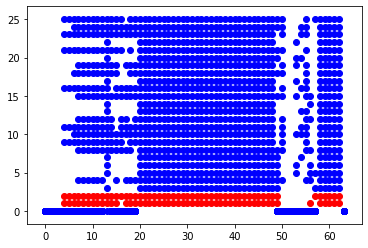

In [60]:
plt.scatter(range(1960-1896),datar[1] * (1), c = 'r')
plt.scatter(range(1960-1896),datar[6] * (2), c = 'r')
for i in range(30):
    plt.scatter(range(1960-1896),datae[i] * (i+3), c = 'b')

In [ ]:
datad = np.array(datad)
CORD = np.corrcoef(datad)

for i in range(30):
    CORD[i,i] = 0
    
print(CORD.shape)

print(np.sum(CORD) / (30*30 - 30))
print(np.max(CORD))

In [ ]:
DATA = np.zeros((30,24*60), int)

f, ax = plt.subplots(1,1)
f.set_figwidth(12)
for i in range(30):
    mins = data[i]
    temp = []
    for m in mins:
        if m.date() == num_date(1954):
            temp.append(m)
    ax.scatter(temp,np.ones(len(temp)) * (i+1))
    
    for m in temp:
        k = int( ((m - datetime(2014,9,14)).seconds) / 60 )
        DATA[i,k] = 1
        
ax.set_xlim(num_date(1954),num_date(1955))

In [ ]:
COR = np.corrcoef(DATA)

for i in range(16):
    COR[i,i] = 0

print(np.sum(COR) / (16*15))
print(np.max(COR))

In [ ]:
f, ax = plt.subplots(1,1)
f.set_figwidth(12)
print(fd,ld)

#fd -= 10
#ld -= 10

for i in range(len(data)):
    mins = data[i]
    ax.scatter(mins, np.ones(len(mins)) * (i+1), marker = '|')
#    if i == 30: break
ax.set_xlim(num_date(1954),num_date(1955))
months_fmt = mdates.DateFormatter('%H.%M')
ax.xaxis.set_major_formatter(months_fmt)
ax.get_yaxis().set_visible(False)

In [ ]:
unclustered = loc[0]

new_bdm = bin_data_m[unclustered]
new_dist_j = sklearn.metrics.pairwise_distances(new_bdm, metric='jaccard')

In [ ]:
best_eps = 0.5
best_min = 10

In [ ]:
ls = cluster(new_dist_j, best_eps, best_min)
print(score_clustering(ls, new_dist_j))
labels = np.array(ls) + 1
index, size = np.unique(labels, return_counts=True)
print(size[1:].tolist())
print(np.sum(size[1:]))
print(size[0])
loc2 = list_cls(labels)
sizes = list(map(len, loc2))
sizes = np.array(sizes)
print(np.mean(sizes[1:]))

In [ ]:
pick(loc2, 'loc2')
print('clusters: ', len(loc2))
for x in range(len(loc2)):
    present_cluster(loc2[x])
    if x == 1: break

In [ ]:
for i in range(10):
    cl = i
    group = loc2[cl].copy()
    bdm = bin_data_m

    k = 0
    f, ax = plt.subplots(1,1)
    #if h > 30: h = 10
    #f.set_figheight(h)
    f.set_figwidth(12)
    temp = np.zeros(3331,int)
    for i in group:
        k += 1
        x = bdm[i]
        temp += x
        ax.scatter(day_x,x * k, marker = '|')
        if k == 15: break
    temp = np.nonzero(temp)
    fd = int(temp[0][0])
    ld = int(temp[0][-1])
#    if(ld - fd) > 999: ld = fd + 500
    if(ld - fd) > 999: fd = ld - 500
    print(fd,ld)
    #plt.autofmt_xdate()
    ax.set_xlim(num_date(fd - 5),num_date(ld + 5))
    ax.get_yaxis().set_visible(False)
    #ax.axvline(num_date(2090 - 1), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 3), c = 'r', linestyle = ':')
    #ax.axvline(num_date(2090 - 31), c = 'b', linestyle = ':')
    #ax.axvline(num_date(2090 - 33), c = 'b', linestyle = ':')
    from datetime import datetime
    import matplotlib.dates as mdates
    months = mdates.MonthLocator()
    days = mdates.DayLocator()
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months_fmt = mdates.DateFormatter('%m/%Y')
    months_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(months)
    plt.title('Cluster ' + str(cl))
    plt.ylim(0.5,k+0.5)
    plt.show()

In [ ]:
sparse = []
for i in range(3667):
    nums = []
    data = bin_data_m[i]
    for j in range(3331):
        if data[j] == 1:nums.append(j)
    sparse.append(nums)

In [ ]:
X = 0
for i in range(3667):
    X += len(sparse[i])
print(X)

In [ ]:
pick(sparse,'sparse')

In [ ]:
sparse2 = np.array(bin_data_m, dtype = bool)

In [ ]:
pick(sparse2,'sparse2')